---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
license: "CC BY"
copyright: 
  holder: Matthew Reda
  year: 2025
citation: true
---

# Centering in Panel Models

> A detailed analysis of centering and some normalization missadventures in panel regression WIP

---
abstract: |
    Panel regression models analyze data from the same units observed over multiple time periods, enabling control for time-invariant unobserved unit characteristics and estimation of within-unit effects. A common technique, particularly in fixed-effects models, involves "demeaning" – subtracting unit-specific means from both dependent and independent variables to isolate within-unit variation. While powerful, this and related centering approaches have pitfalls: they preclude estimation of time-invariant predictor effects, and coefficients reflect purely within-unit changes, which may differ from between-unit or overall effects. Such methods focus analysis on within-unit variation, potentially overlooking broader patterns if this variation is minimal, and can complicate the interpretation of interaction terms. Centering techniques can also be missapplied, for example by only being applied to the dependent variable or by dividing by instead of subtracting the group level mean. Consequently, the choice of centering technique fundamentally shapes the questions being addressed and the interpretation of results.
---

In [ ]:
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from tueplots import bundles
from tueplots.constants.color import rgb
from common_regression_issues.utils.plotting import rgb_to_hex
import statsmodels.api as sm
import linearmodels as lm

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

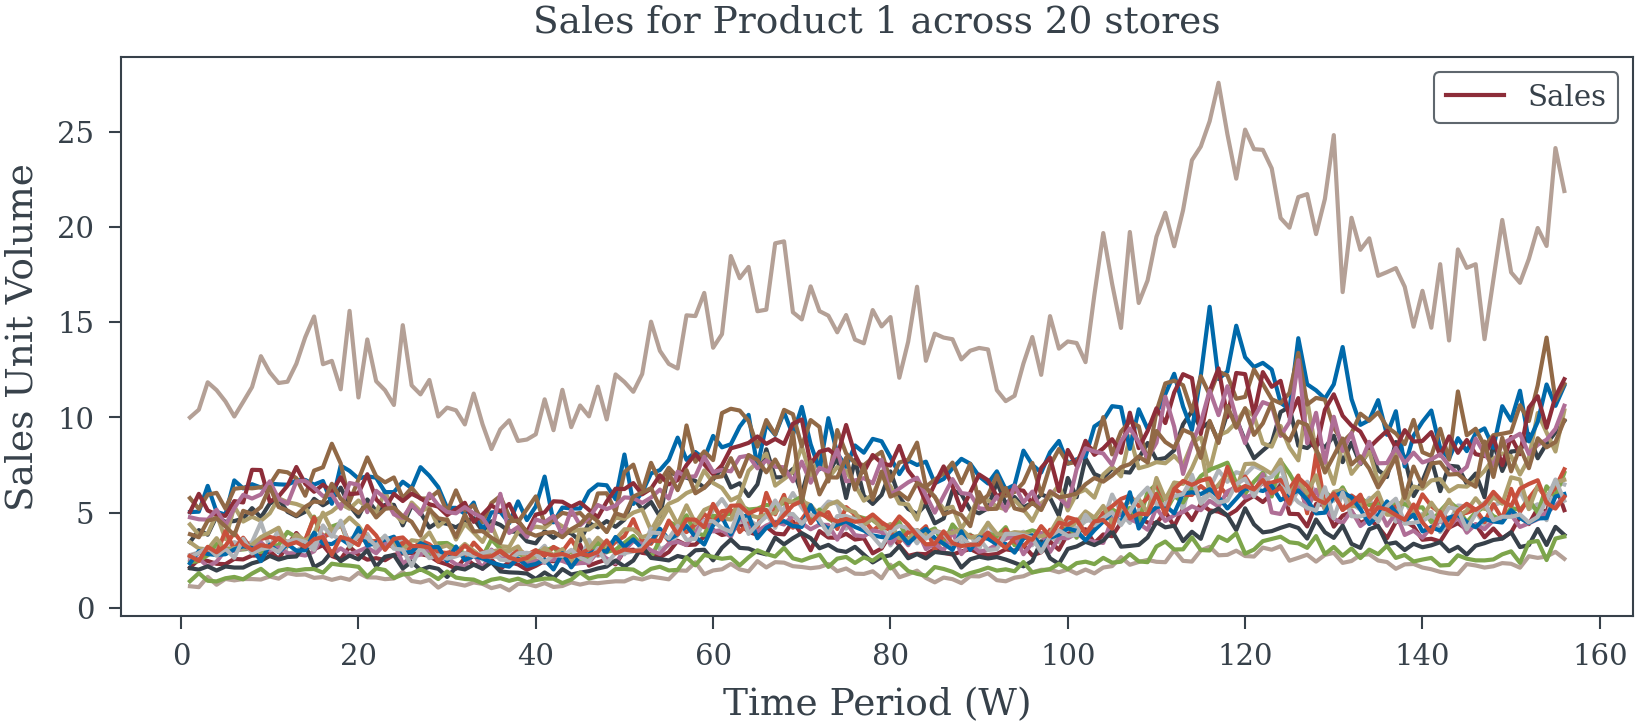

In [ ]:
#| hide
def generate_synthetic_sales_data_xarray(N_stores, T_periods, K_products, seed=None):
    """
    Generates synthetic sales data in panel format using xarray.
    Sales are strictly positive.

    Args:
        N_stores (int): Number of stores (cross-sectional units).
        T_periods (int): Number of time periods.
        K_products (int): Number of product categories.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        xarray.Dataset: An xarray Dataset containing the generated sales data.
                        Dimensions are 'store_id', 'time_period', 'product_id'.
                        The data variable is 'sales'.
    """
    if seed is not None:
        np.random.seed(seed)

    # Define coordinates
    store_coords = np.arange(1, N_stores + 1)
    time_coords = np.arange(1, T_periods + 1)
    product_coords = np.arange(1, K_products + 1)

    # --- Generate components for log_sales ---

    # Base log-sales for each product
    base_log_sales_per_product = np.random.uniform(0.5, 2.5, K_products)

    # Store-specific effects (log-scale)
    store_effects = np.random.randn(N_stores) * 0.4

    # Time-specific effects
    time_values = np.arange(T_periods)
    # Trend component
    trend_slope = np.random.uniform(0.005, 0.015) * 1
    time_trend = trend_slope * time_values
    # Seasonality component
    seasonality_amplitude = np.random.uniform(0.1, 0.3)*1
    # num_seasonal_cycles = max(1, int(T_periods / 12)) # e.g. approx monthly seasonality if T_periods is large
    seasonality_period = 52 #T_periods / num_seasonal_cycles if num_seasonal_cycles > 0 else T_periods
    if seasonality_period == 0: # Avoid division by zero if T_periods is 0
        seasonality_period = 1 
    time_seasonality = seasonality_amplitude * np.sin(2 * np.pi * time_values / seasonality_period)
    
    total_time_effects = time_trend + time_seasonality

    # Idiosyncratic random noise (log-scale)
    log_noise = np.random.randn(N_stores, T_periods, K_products) * 0.1

    # --- Combine components to form log_sales ---
    # log_sales_ipt = base_p + store_i + time_t + noise_ipt
    log_sales = (base_log_sales_per_product[np.newaxis, np.newaxis, :] +
                 store_effects[:, np.newaxis, np.newaxis] +
                 total_time_effects[np.newaxis, :, np.newaxis] +
                 log_noise)

    # --- Transform to sales (ensuring positivity) ---
    sales_values = np.exp(log_sales)

    # Create xarray Dataset
    dataset = xr.Dataset(
        data_vars={'sales': (('store_id', 'time_period', 'product_id'), sales_values)},
        coords={
            'store_id': store_coords,
            'time_period': time_coords,
            'product_id': product_coords
        }
    )

    return dataset

# Example usage:
N_stores_demo = 20
T_periods_demo = 156 # e.g., 2 years of weekly data
K_products_demo = 1 # e.g., 1 product category
sales_demo_data = generate_synthetic_sales_data_xarray(N_stores_demo, T_periods_demo, K_products_demo, seed=42)


# Plot sales for the first product across all stores
if K_products_demo > 0:
    lines = sales_demo_data.sales.sel(product_id=1).plot.line(x='time_period', hue='store_id')
    plt.title(f"Sales for Product 1 across {N_stores_demo} stores")
    plt.ylabel("Sales Unit Volume")
    plt.xlabel("Time Period (W)")
    plt.legend(lines[:1], ['Sales']);
    

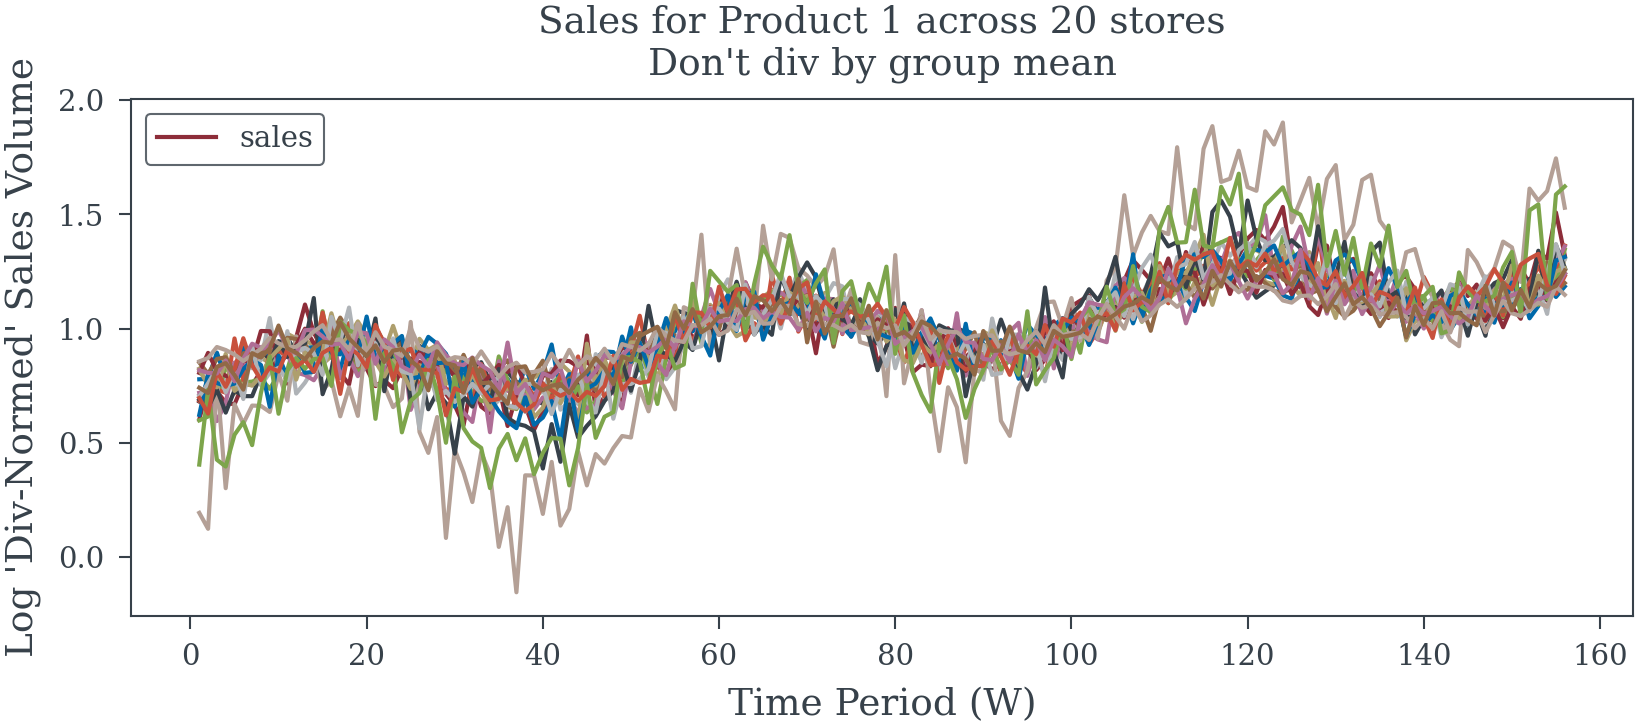

In [ ]:
#| hide
sales_normed = (np.log(sales_demo_data.sales)/np.log(sales_demo_data.sales).mean(dim='time_period')).sel(product_id=1)
lines = sales_normed.plot.line(x='time_period', hue='store_id')
plt.title(f"Sales for Product 1 across {N_stores_demo} stores\nDon't div by group mean")
plt.ylabel("Log 'Div-Normed' Sales Volume")
plt.xlabel("Time Period (W)")
plt.legend(lines[:1], ['sales']);


In [ ]:
time_index = sales_normed.time_period.values.astype(int)

seasonal_control = np.sin(2 * np.pi * time_index / 52)
trend = time_index/52

# Fit a linear regression model
sales_df = sales_demo_data.to_dataframe().reset_index()
control_df = pd.DataFrame({
    'seasonal_control': seasonal_control,
    'trend': trend,
    'time_period': time_index
})
control_df['time_period'] = control_df['time_period']

total_df = sales_df.merge(control_df, on='time_period',  how='left')

train_df = total_df[total_df['time_period'] < 104].copy().set_index(['store_id', 'time_period'])
test_df = total_df[total_df['time_period'] >= 104].copy().set_index(['store_id', 'time_period'])

# Creat the dependent variable and independent variables
X_train = sm.add_constant(train_df[['seasonal_control', 'trend']])
y_train = np.log(train_df['sales'])
y_train_div = y_train/y_train.groupby('store_id').mean()
y_train_sub = y_train-y_train.groupby('store_id').mean()

# Fit the regression model
ME_model_standard = lm.RandomEffects(y_train, X_train)
ME_model_div = lm.RandomEffects(y_train_div, X_train)
ME_model_sub = lm.RandomEffects(y_train_sub, X_train)

# Fit the model
fitted_model_standard = ME_model_standard.fit()
fitted_model_div = ME_model_div.fit()
fitted_model_sub = ME_model_sub.fit()

::: {.panel-tabset}

## Div 'Normed' Model

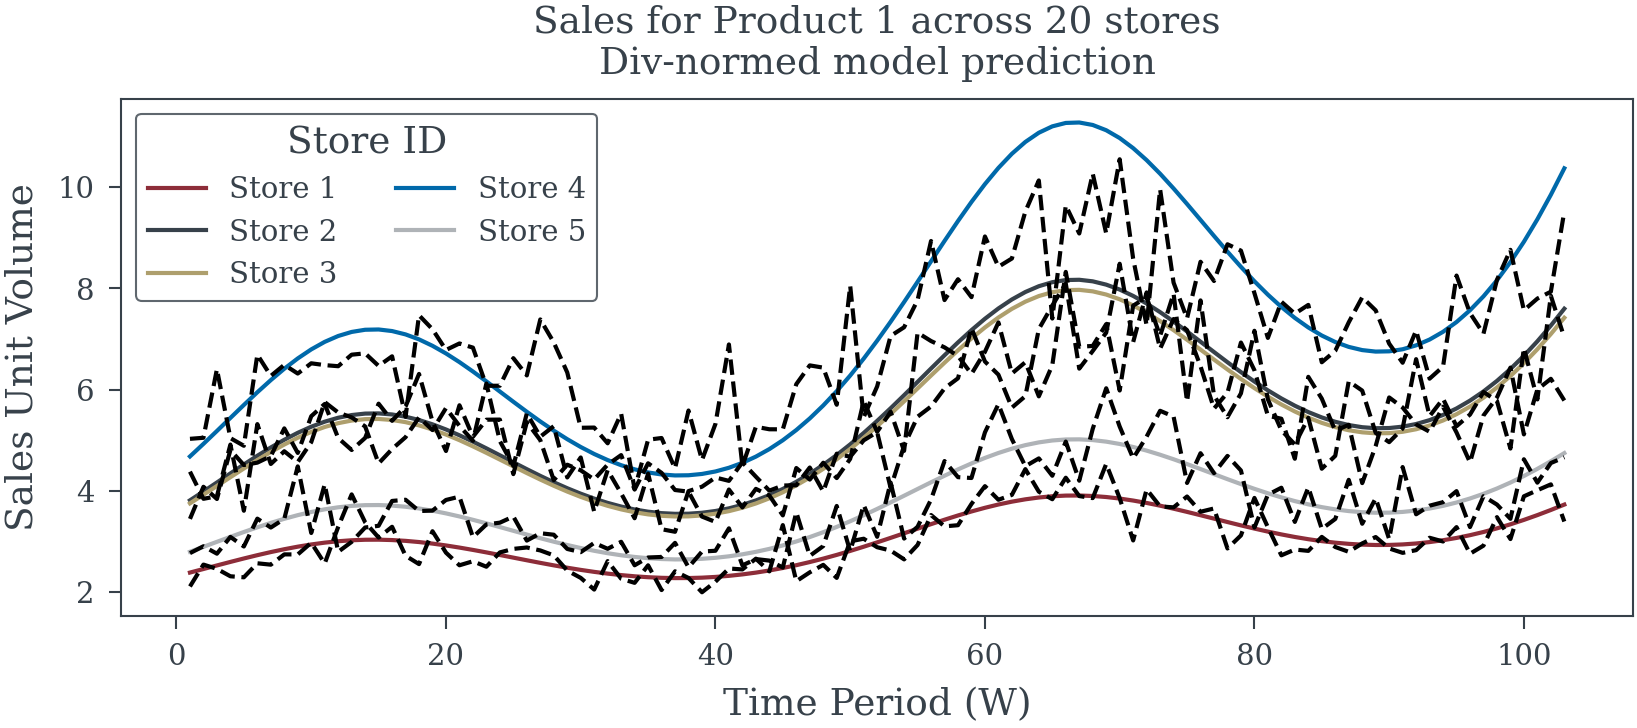

In [ ]:
#| echo: false
#| label: fig-div-normed-model
#| fig-cap: "Sales model fitted with div-normed dependent variable"
prediction_div = xr.Dataset.from_dataframe(fitted_model_div.predict(effects=True))
mean_store = xr.DataArray.from_series(y_train.groupby('store_id').mean())
train_actual = xr.Dataset.from_dataframe((train_df[['sales']]))

lines = (np.exp((prediction_div.fitted_values+prediction_div.estimated_effects.mean('time_period') + (fitted_model_div.variance_decomposition['Residual'])/2)*mean_store)).isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id')
train_actual.sales.isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', color='black', linestyle='--')
plt.legend(lines[:5], [f"Store {i}" for i in range(1, 6)], title="Store ID", ncol=2)
plt.title(f"Sales for Product 1 across {N_stores_demo} stores\nDiv-normed model prediction")
plt.ylabel("Sales Unit Volume")
plt.xlabel("Time Period (W)");


::: {.callout-note collapse=true}
## Model Summary

In [ ]:
fitted_model_div.summary

Dep. Variable:,sales,R-squared:,0.6094
Estimator:,RandomEffects,R-squared (Between):,0.0000
No. Observations:,2060,R-squared (Within):,0.6094
Date:,"Sat, May 17 2025",R-squared (Overall):,0.6094
Time:,23:39:36,Log-likelihood,1484.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1604.9
Entities:,20,P-value,0.0000
Avg Obs:,103.00,Distribution:,"F(2,2057)"
Min Obs:,103.00,,
Max Obs:,103.00,F-statistic (robust):,1604.9


In [ ]:
fitted_model_div.variance_decomposition

Effects                   0.00000
Residual                  0.01401
Percent due to Effects    0.00000
Name: Variance Decomposition, dtype: float64

:::

## Standard MEM

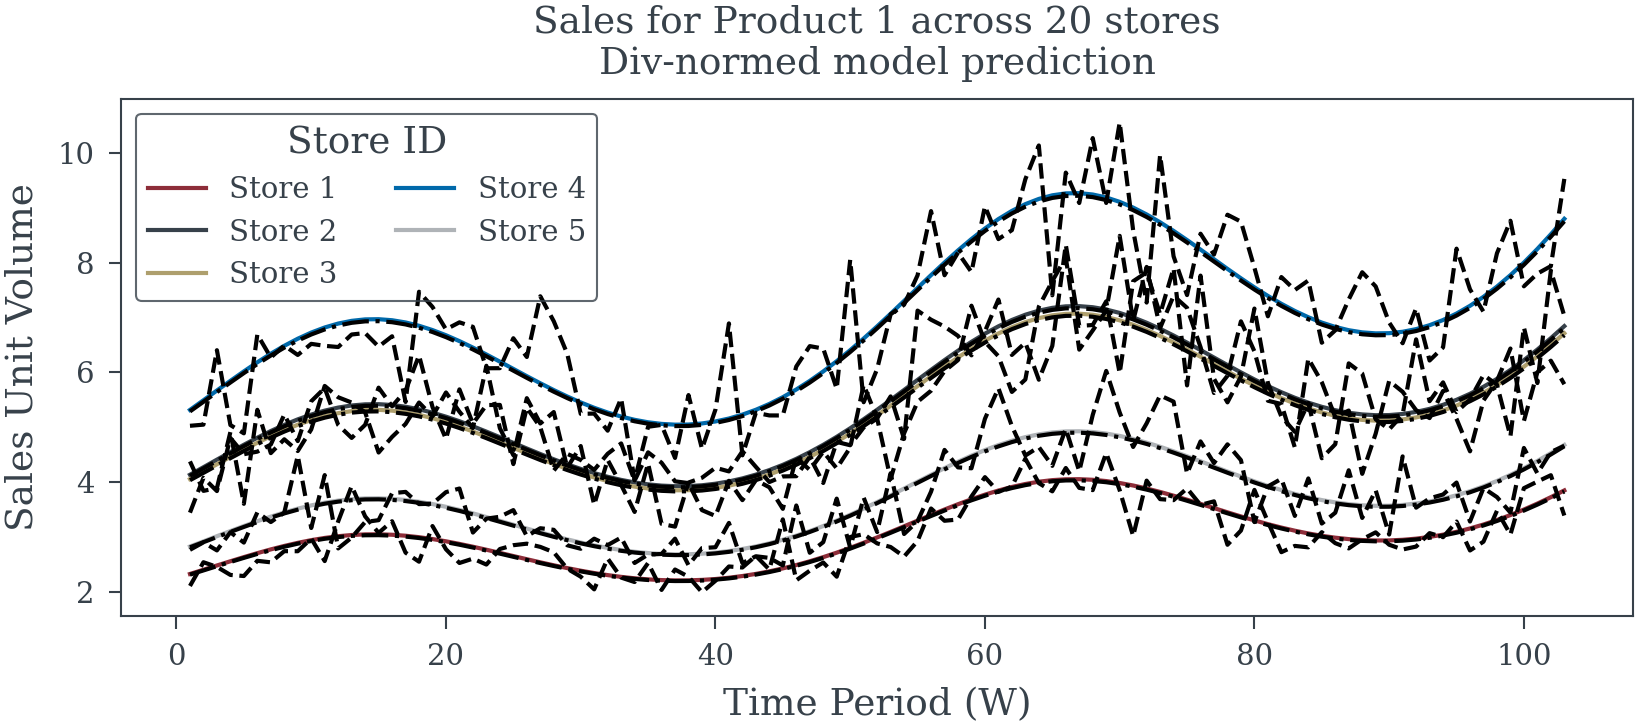

In [ ]:
#| echo: false
#| label: fig-stand-normed-model
#| fig-cap: "Sales model fitted with non-normed dependent variable"
prediction = xr.Dataset.from_dataframe(fitted_model_standard.predict(effects=True))

uncorrected_predicted_sales = np.exp(prediction.fitted_values+prediction.estimated_effects.mean('time_period'))
corrected_predicted_sales = np.exp(prediction.fitted_values+prediction.estimated_effects.mean('time_period') + (fitted_model_standard.variance_decomposition['Residual'])/2)
lines = corrected_predicted_sales.isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id')
uncorrected_predicted_sales.isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', color='black', linestyle='-.')
train_actual.sales.isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', color='black', linestyle='--')
plt.legend(lines[:5], [f"Store {i}" for i in range(1, 6)], title="Store ID", ncol=2)
plt.title(f"Sales for Product 1 across {N_stores_demo} stores\nDiv-normed model prediction")
plt.ylabel("Sales Unit Volume")
plt.xlabel("Time Period (W)");


::: {.callout-note collapse=true}
## Model summary

In [ ]:
fitted_model_standard.summary

Dep. Variable:,sales,R-squared:,0.7553
Estimator:,RandomEffects,R-squared (Between):,2.22e-16
No. Observations:,2060,R-squared (Within):,0.7569
Date:,"Sat, May 17 2025",R-squared (Overall):,0.1244
Time:,23:39:36,Log-likelihood,1783.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3174.9
Entities:,20,P-value,0.0000
Avg Obs:,103.00,Distribution:,"F(2,2057)"
Min Obs:,103.00,,
Max Obs:,103.00,F-statistic (robust):,3174.9


In [ ]:
fitted_model_standard.variance_decomposition

Effects                   0.252757
Residual                  0.010390
Percent due to Effects    0.960517
Name: Variance Decomposition, dtype: float64

:::

## Comparison of Normalization

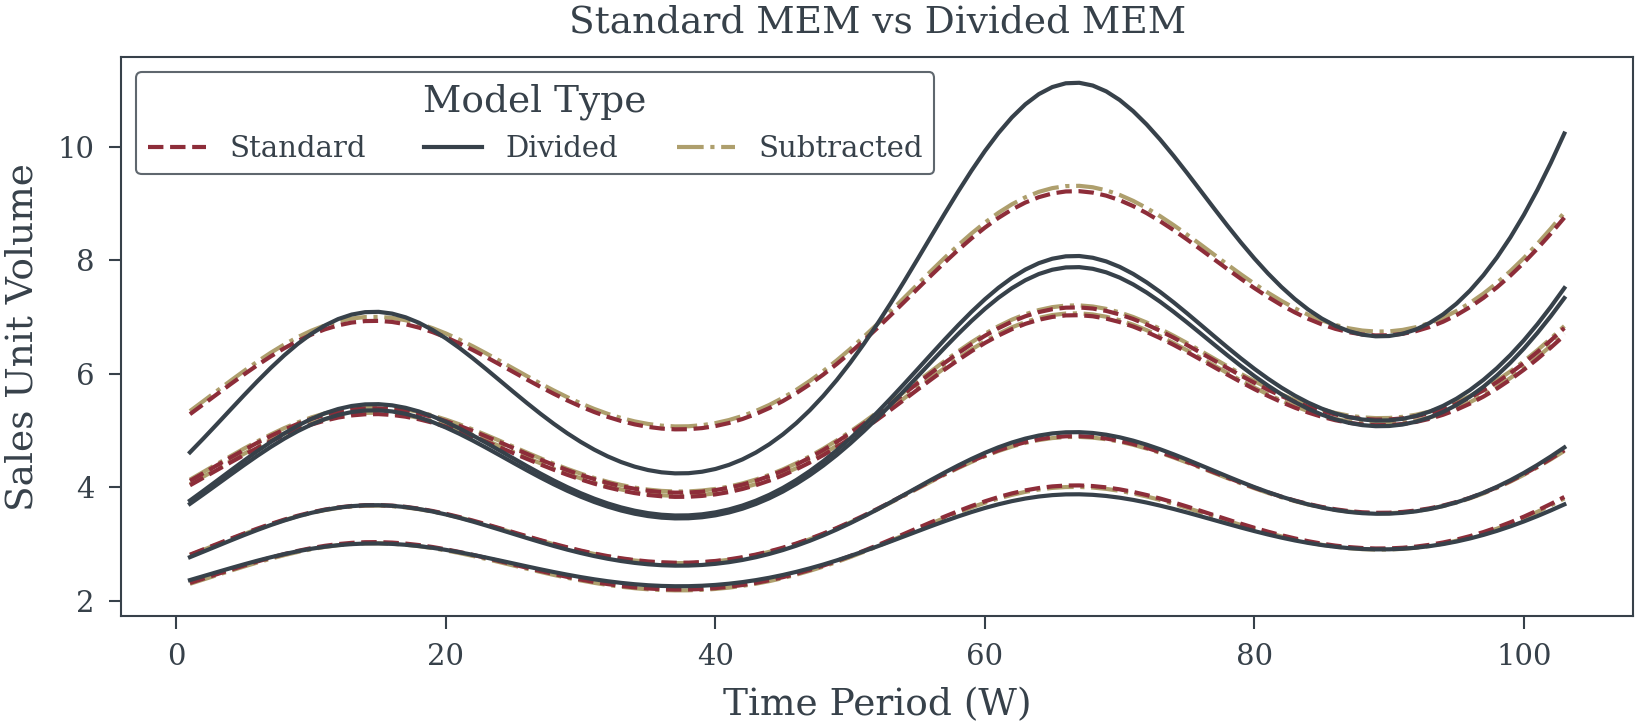

In [ ]:
#| echo: false
#| label: fig-mem-divided
#| fig-cap: "The divided MEM model and the standard MEM model produce much different prediction. Using the wrong model structure will produce biased predictions, and missleading results."
prediction_sub = xr.Dataset.from_dataframe(fitted_model_sub.predict(effects=True))
mean_store = xr.DataArray.from_series(y_train.groupby('store_id').mean())
train_actual = xr.Dataset.from_dataframe((train_df[['sales']]))
lines_sub = np.exp(prediction_sub.fitted_values + mean_store).isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', linestyle='-.', color='C2');

lines_std = np.exp(prediction.fitted_values+prediction.estimated_effects.mean("time_period")).isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', linestyle='--', color='C0')
lines_div = (np.exp((prediction_div.fitted_values+prediction_div.estimated_effects.mean('time_period'))*mean_store)).isel(store_id=slice(5)).plot.line(x='time_period', hue='store_id', color='C1')
plt.legend([lines_std[0], lines_div[0], lines_sub[0]], ["Standard", "Divided", "Subtracted"], title="Model Type", ncol=3)
plt.title("Standard MEM vs Divided MEM")
plt.ylabel("Sales Unit Volume")
plt.xlabel("Time Period (W)");

:::